# Transfer Learning: VGG16

In [1]:
import numpy as np
import pandas as pd
import keras
from keras.applications import VGG16
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten, BatchNormalization, Input
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Model
from keras.utils import np_utils
from keras.optimizers import Adamax
import matplotlib.pyplot as plt
import os.path
from keras.models import load_model
import sys
np.random.seed(7)
from sklearn.metrics import confusion_matrix

EMOTIONS = [
  'Angry',
  'Disgust',
  'Fear',
  'Happy',
  'Sad',
  'Surprise',
  'Neutral',
]

Using TensorFlow backend.


In [2]:
X_train = np.load('data files/X_train.npy')
y_train = np.load('data files/y_train.npy')

X_test = np.load('data files/X_test.npy')
y_test = np.load('data files/y_test.npy')

X_val = np.load('data files/X_val.npy')
y_val = np.load('data files/y_val.npy')

print("X_train shape:", X_train.shape, "y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape, "y_test shape:", y_test.shape)

X_train shape: (57418, 48, 48) y_train shape: (57418,)
X_test shape: (3589, 48, 48) y_test shape: (3589,)


In [3]:
#Prepare inputs for Keras CNN model

X_train = X_train.reshape(X_train.shape[0], 48, 48, 1)
X_train = X_train.astype('float32')

X_val = X_val.reshape(X_val.shape[0], 48, 48, 1)
X_val = X_val.astype('float32')

X_test = X_test.reshape(X_test.shape[0], 48, 48, 1)
X_test = X_test.astype('float32')

print("X_train shape:", X_train.shape, "y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape, "y_val shape:", y_val.shape)
print("X_test shape:", X_test.shape, "y_test shape:", y_test.shape)

y_train = np_utils.to_categorical(y_train, 7)
y_val = np_utils.to_categorical(y_val, 7)
y_test = np_utils.to_categorical(y_test, 7)

num_classes = y_test.shape[1]

X_train shape: (57418, 48, 48, 1) y_train shape: (57418,)
X_val shape: (3589, 48, 48, 1) y_val shape: (3589,)
X_test shape: (3589, 48, 48, 1) y_test shape: (3589,)


In [ ]:
#Load the model if trained model present and evaluate directly on test data

if os.path.exists('models/vgg16_model_tunned.h5'):
    model = load_model('models/vgg16_model_tunned.h5')
    print('Model loaded Successfully!')
else:
    print('No model to load !')

In [4]:
#Convert inputs from 1-channel images to 3-channel for VGG16 model

X_train_expanded = np.zeros((X_train.shape[0], X_train.shape[1], X_train.shape[2], 3))
X_train_expanded[:, :, :, 0] = X_train[:, :, :, 0]
X_train_expanded[:, :, :, 1] = X_train[:, :, :, 0]
X_train_expanded[:, :, :, 2] = X_train[:, :, :, 0]

X_val_expanded = np.zeros((X_val.shape[0], X_val.shape[1], X_val.shape[2], 3))
X_val_expanded[:, :, :, 0] = X_val[:, :, :, 0]
X_val_expanded[:, :, :, 1] = X_val[:, :, :, 0]
X_val_expanded[:, :, :, 2] = X_val[:, :, :, 0]

X_test_expanded = np.zeros((X_test.shape[0], X_test.shape[1], X_test.shape[2], 3))
X_test_expanded[:, :, :, 0] = X_test[:, :, :, 0]
X_test_expanded[:, :, :, 1] = X_test[:, :, :, 0]
X_test_expanded[:, :, :, 2] = X_test[:, :, :, 0]

X_train = X_train_expanded
X_val = X_val_expanded
X_test = X_test_expanded

N_train = int(len(X_train))
N_val = int(len(X_val))
N_test = int(len(X_test))

print("X_train shape:", X_train.shape, "y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape, "y_val shape:", y_val.shape)
print("X_test shape:", X_test.shape, "y_test shape:", y_test.shape)

X_train shape: (57418, 48, 48, 3) y_train shape: (57418, 7)
X_val shape: (3589, 48, 48, 3) y_val shape: (3589, 7)
X_test shape: (3589, 48, 48, 3) y_test shape: (3589, 7)


### VGG16 as Feature Extracter

In [5]:
# Load vgg16 model without top 3 FC layers

vgg = VGG16(include_top=False, input_shape=(48, 48, 3),
                    pooling='max', weights='imagenet')
vgg.trainable = False
vgg.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 48, 48, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 48, 48, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 48, 48, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 24, 24, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 24, 24, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 24, 24, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 12, 12, 128)       0         
__________

In [6]:
#Extract feauture maps from input data using Vgg16 model

def get_vgg16_feature(vgg, vgg_input, n_feature_maps):
    
    picture_train_features = vgg.predict(vgg_input)
    del (vgg_input)

    feature_map = np.empty([n_feature_maps, 512])
    
    for idx, picture in enumerate(picture_train_features):
        feature_map[idx] = picture
        
    return feature_map


x_train_feature_map = get_vgg16_feature(vgg, X_train, N_train)
x_val_feature_map = get_vgg16_feature(vgg, X_val, N_val)
x_test_feature_map = get_vgg16_feature(vgg, X_test, N_test)

In [7]:
#Build 3-FC layer model

model = Sequential()

model.add(Dense(512, input_shape=(512,)))
model.add(Activation('relu'))
model.add(Dropout(0.3))

model.add(Dense(256, input_shape=(512,)))
model.add(Activation('relu'))
model.add(Dropout(0.3))

model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
activation_1 (Activation)    (None, 512)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
activation_2 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 7)                 1799      
__________

In [8]:
adamax = Adamax()

#Compile the model
model.compile(loss='categorical_crossentropy',
             optimizer='adamax',
             metrics=['accuracy'])

In [9]:
#Train our FC model with training data

history = model.fit(x_train_feature_map,y_train,validation_data = (x_val_feature_map, y_val), 
                    epochs=50,batch_size=128,verbose=1)

Train on 57418 samples, validate on 3589 samples
Epoch 1/50
57418/57418 [==============================] - 2s 38us/step - loss: 1.6095 - acc: 0.3670 - val_loss: 1.5188 - val_acc: 0.4001
Epoch 2/50
57418/57418 [==============================] - 2s 28us/step - loss: 1.5048 - acc: 0.4203 - val_loss: 1.4809 - val_acc: 0.4213
Epoch 3/50
57418/57418 [==============================] - 2s 29us/step - loss: 1.4559 - acc: 0.4428 - val_loss: 1.4568 - val_acc: 0.4413
Epoch 4/50
57418/57418 [==============================] - 2s 29us/step - loss: 1.4134 - acc: 0.4589 - val_loss: 1.4483 - val_acc: 0.4402
Epoch 5/50
57418/57418 [==============================] - 2s 29us/step - loss: 1.3699 - acc: 0.4787 - val_loss: 1.4322 - val_acc: 0.4542
Epoch 6/50
57418/57418 [==============================] - 2s 28us/step - loss: 1.3300 - acc: 0.4954 - val_loss: 1.4175 - val_acc: 0.4511
Epoch 7/50
57418/57418 [==============================] - 2s 29us/step - loss: 1.2929 - acc: 0.5127 - val_loss: 1.4219 - val_acc:

In [10]:
#Merge our trained FC model with Vgg16 model

inputs = Input(shape=(48, 48, 3))
vgg_output = vgg(inputs)

model_predictions = model(vgg_output)
final_model = Model(input=inputs, output=model_predictions)

/home/ckadam/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("se...)`
  import sys


In [11]:
#Compile the model
final_model.compile(loss='categorical_crossentropy',
             optimizer='adamax',
             metrics=['accuracy'])


===> Results: VGG16: Feature Extracter <===

Training Accuracy: 77.48%
Validation Accuracy: 48.04%


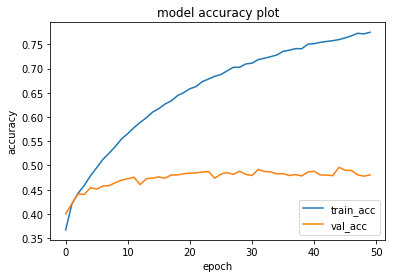

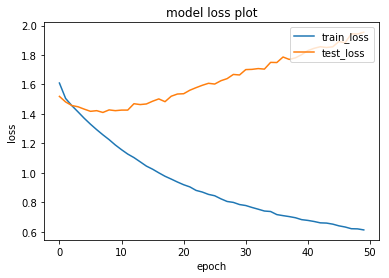


Evaluating model on test data
3589/3589 [==============================] - 1s 292us/step

Test Accuracy: 49.51%

Loss: 1.93


In [12]:
# Save the model in HDF5 file 
final_model.save('models/vgg16_model.h5')

# Visualize model plots and save in image format
from keras.utils import plot_model
import pydot
plot_model(final_model, to_file='models/vgg16_model_tunned.png', show_shapes=True)

# Output training results

train_acc = history.history['acc']
val_acc = history.history['val_acc']

print("\n===> Results: VGG16: Feature Extracter <===")
print("\nTraining Accuracy: %.2f%%" % ((train_acc[-1])*100))
print("Validation Accuracy: %.2f%%" % ((val_acc[-1])*100))

# Plot accuracy result
plt.plot(train_acc)
plt.title('model accuracy plot')
plt.ylabel('accuracy')
plt.plot(val_acc)
plt.xlabel('epoch')
plt.legend(['train_acc', 'val_acc'], loc='lower right')
plt.show()

# Plot loss result
plt.plot(history.history['loss'])
plt.title('model loss plot')
plt.ylabel('loss')
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.legend(['train_loss', 'test_loss'], loc='upper right')
plt.show()

print("\nEvaluating model on test data")
scores = final_model.evaluate(X_test,y_test)

print("\nTest Accuracy: %.2f%%" % (scores[1]*100))
print("\nLoss: %.2f" % (scores[0]))

### VGG16 - Fine Tuning on FER dataset

In [13]:
# Load new vgg model to fine tune

vgg1 = VGG16(include_top=False, input_shape=(48, 48, 3),
                    pooling='max', weights='imagenet')

In [ ]:
# Freeze number of layers if you want
#for layer in vgg1.layers[:-9]:
    #layer.trainable = False
    
# Cheeck trainable status of each layer
#for layer in vgg1.layers:
    #print(layer, layer.trainable)

In [14]:
#Build new model with above VGG16 and new 3-FC layers

model1 = Sequential()

model1.add(vgg1)

model1.add(Dense(512, input_shape=(512,)))
model1.add(Activation('relu'))
model1.add(Dropout(0.3))

model1.add(Dense(256, input_shape=(512,)))
model1.add(Activation('relu'))
model1.add(Dropout(0.3))

model1.add(Dense(num_classes))
model1.add(Activation('softmax'))

model1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 512)               14714688  
_________________________________________________________________
dense_4 (Dense)              (None, 512)               262656    
_________________________________________________________________
activation_4 (Activation)    (None, 512)               0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               131328    
_________________________________________________________________
activation_5 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
__________

In [15]:
#Compile the model
model1.compile(loss='categorical_crossentropy',
             optimizer='adamax',
             metrics=['accuracy'])

In [16]:
#Fit the model
history1 = model1.fit(X_train,y_train,validation_data = (X_val, y_val), epochs=40,batch_size=128,verbose=1)

Train on 57418 samples, validate on 3589 samples
Epoch 1/40
57418/57418 [==============================] - 31s 548us/step - loss: 1.7147 - acc: 0.3029 - val_loss: 1.4293 - val_acc: 0.4517
Epoch 2/40
57418/57418 [==============================] - 30s 517us/step - loss: 1.3129 - acc: 0.4955 - val_loss: 1.1839 - val_acc: 0.5430
Epoch 3/40
57418/57418 [==============================] - 30s 518us/step - loss: 1.1695 - acc: 0.5540 - val_loss: 1.1809 - val_acc: 0.5489
Epoch 4/40
57418/57418 [==============================] - 30s 520us/step - loss: 1.0699 - acc: 0.5961 - val_loss: 1.1017 - val_acc: 0.5821
Epoch 5/40
57418/57418 [==============================] - 30s 521us/step - loss: 0.9749 - acc: 0.6368 - val_loss: 1.0436 - val_acc: 0.6069
Epoch 6/40
57418/57418 [==============================] - 30s 524us/step - loss: 0.8792 - acc: 0.6760 - val_loss: 1.0344 - val_acc: 0.6300
Epoch 7/40
57418/57418 [==============================] - 30s 525us/step - loss: 0.7788 - acc: 0.7164 - val_loss: 1.0


===> Results: VGG16: Fine Tunned <===

Training Accuracy: 98.88%
Validation Accuracy: 66.29%


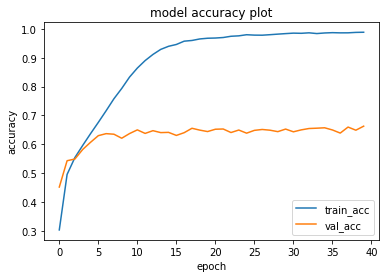

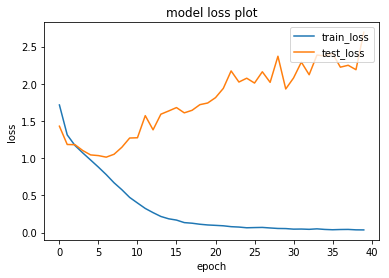


Evaluating model on test data
3589/3589 [==============================] - 1s 262us/step

Test Accuracy: 65.00%

Loss: 2.85


In [17]:
# Save the model in HDF5 file 
model1.save('models/vgg16_model_tunned.h5')

# Visualize model plots and save in image format
from keras.utils import plot_model
import pydot
plot_model(model1, to_file='models/vgg16_model_tunned.png', show_shapes=True)

# Output training results

train_acc = history1.history['acc']
val_acc = history1.history['val_acc']

print("\n===> Results: VGG16: Fine Tunned <===")
print("\nTraining Accuracy: %.2f%%" % ((train_acc[-1])*100))
print("Validation Accuracy: %.2f%%" % ((val_acc[-1])*100))

# Plot accuracy result
plt.plot(train_acc)
plt.title('model accuracy plot')
plt.ylabel('accuracy')
plt.plot(val_acc)
plt.xlabel('epoch')
plt.legend(['train_acc', 'val_acc'], loc='lower right')
plt.show()

# Plot loss result
plt.plot(history1.history['loss'])
plt.title('model loss plot')
plt.ylabel('loss')
plt.plot(history1.history['val_loss'])
plt.xlabel('epoch')
plt.legend(['train_loss', 'test_loss'], loc='upper right')
plt.show()

print("\nEvaluating model on test data")
scores = model1.evaluate(X_test,y_test)

print("\nTest Accuracy: %.2f%%" % (scores[1]*100))
print("\nLoss: %.2f" % (scores[0]))


Confusion matrix for above results:


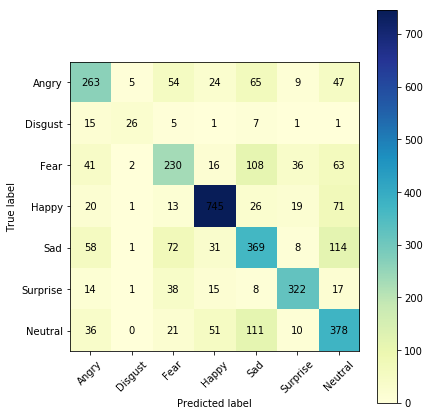

In [19]:
print("\nConfusion matrix for above results:")

y_prob = model1.predict(X_test, batch_size=50, verbose=0)
y_pred = [np.argmax(prob) for prob in y_prob]
y_true = [np.argmax(true) for true in y_test]

def plot_confusion_matrix(y_true, y_pred, cmap=plt.cm.Blues):
    
    cm = confusion_matrix(y_true, y_pred)
    fig = plt.figure(figsize=(6,6))
   # matplotlib.rcParams.update({'font.size': 14})
    ax  = fig.add_subplot(111)
    matrix = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    fig.colorbar(matrix) 
    
    for i in range(0,7):
        for j in range(0,7):  
            ax.text(j,i,cm[i,j],va='center', ha='center')

    ticks = np.arange(len(EMOTIONS))
    ax.set_xticks(ticks)
    ax.set_xticklabels(EMOTIONS, rotation=45)
    ax.set_yticks(ticks)
    ax.set_yticklabels(EMOTIONS)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
plot_confusion_matrix(y_true, y_pred, cmap=plt.cm.YlGnBu)